In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
PATH = "C:/Users/rahul/Desktop/Final Year Project/Datasets"
T1 = PATH + "/Inputs & output.xlsx"

In [4]:
data = pd.read_excel(T1, header = 1)

In [5]:
data = data.drop("Number", axis=1)
data = data.drop("Biomass type", axis=1)

In [6]:
data

,M,VM,FC,A,C,O,H,N,S,T (˚C),AFR (kg/kg),Wnet (kW)
0,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,1.8,50.646995
1,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.0,47.490069
2,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.3,44.021257
3,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,1.8,103.090293
4,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,2.0,98.030617
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.0,65.234100
1028,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.3,57.348570
1029,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,1.8,96.825749
1030,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,2.0,92.012450


In [7]:
X = data.iloc[:, :11]
X = X.to_numpy(dtype=float)
X.shape

(1032, 11)

In [8]:
X[2]

array([5.26000e+01, 7.66000e+01, 1.92000e+01, 4.20000e+00, 5.09656e+01,
       3.85116e+01, 5.84380e+00, 4.79000e-01, 0.00000e+00, 6.00000e+02,
       2.30000e+00])

In [9]:
Y = data.iloc[:, 11:]
Y = Y.to_numpy(dtype=float)
Y.shape

(1032, 1)

In [10]:
Y[2]

array([44.0212568])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 Ti'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/5, random_state = 1)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [13]:
X_test[2]

array([-0.34353008, -0.17485219, -0.24360851, -0.35638173, -0.20954265,
       -0.23296478, -0.34601559, -0.36100575, -0.36506559,  4.45399026,
       -0.35895206])

In [14]:
y_test[2]

array([240.816006])

In [15]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

train_ds = TensorDataset(X_train, y_train)
#test_ds = TensorDataset(X_test, y_test)
torch.manual_seed(1)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.firstlayer = nn.Linear(input_size, hidden_size)
        self.secondlayer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.firstlayer(x)
        x = nn.Sigmoid()(x)
        x = self.secondlayer(x)
        return x

    def predict(self, x):
        pred = self.forward(x)
        return pred

In [17]:
network = NeuralNetwork(11, 40, 1).to(device)

In [18]:
network

NeuralNetwork(
  (firstlayer): Linear(in_features=11, out_features=40, bias=True)
  (secondlayer): Linear(in_features=40, out_features=1, bias=True)
)

In [19]:
network.load_state_dict(torch.load("modelStateDict.pth"))

<All keys matched successfully>

In [21]:
num_epochs = 5000
log_epochs = 100
learning_rate = 0.0002
lossfunc = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_hist = [0] * num_epochs
accuracy_hist = [0]*num_epochs

In [22]:
for epochs in range(num_epochs):
    count = 0
    for x, y in train_dl:
        prediction = network.predict(x)
        loss = lossfunc(prediction, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epochs] += loss.item()*y.size(0)
        if(torch.abs(prediction - y) <= torch.tensor(20)): count += 1
        
    loss_hist[epochs] /= len(train_dl.dataset)
    accuracy_hist[epochs] = count/len(train_dl.dataset)
    if epochs % log_epochs==0:
        print(f'Epoch {epochs} Loss 'f'{loss_hist[epochs]:.4f}')
        print(f'Epoch {epochs} Accuracy 'f'{accuracy_hist[epochs]:.4f}')

Epoch 0 Loss 959.6461
Epoch 0 Accuracy 0.7042
Epoch 100 Loss 957.0939
Epoch 100 Accuracy 0.7055
Epoch 200 Loss 958.8419
Epoch 200 Accuracy 0.7115
Epoch 300 Loss 955.7393
Epoch 300 Accuracy 0.7042
Epoch 400 Loss 950.9749
Epoch 400 Accuracy 0.6933
Epoch 500 Loss 949.8238
Epoch 500 Accuracy 0.7091
Epoch 600 Loss 950.2502
Epoch 600 Accuracy 0.7018
Epoch 700 Loss 946.4042
Epoch 700 Accuracy 0.6958
Epoch 800 Loss 947.7671
Epoch 800 Accuracy 0.7030
Epoch 900 Loss 944.9720
Epoch 900 Accuracy 0.7030
Epoch 1000 Loss 945.1732
Epoch 1000 Accuracy 0.6994
Epoch 1100 Loss 942.6689
Epoch 1100 Accuracy 0.7103
Epoch 1200 Loss 946.3876
Epoch 1200 Accuracy 0.7018
Epoch 1300 Loss 942.3075
Epoch 1300 Accuracy 0.7067
Epoch 1400 Loss 941.4611
Epoch 1400 Accuracy 0.7164
Epoch 1500 Loss 937.5306
Epoch 1500 Accuracy 0.7079
Epoch 1600 Loss 937.3570
Epoch 1600 Accuracy 0.7042
Epoch 1700 Loss 935.8968
Epoch 1700 Accuracy 0.7103
Epoch 1800 Loss 934.3100
Epoch 1800 Accuracy 0.7067
Epoch 1900 Loss 932.4542
Epoch 1900 

In [40]:
import pickle
pickle_in1 = open('loss.pickle', 'rb')
loss_hist_prev = pickle.load(pickle_in1)
pickle_in2 = open('accuracy.pickle', 'rb')
accuracy_hist_prev = pickle.load(pickle_in2)

In [41]:
loss_hist_new = []
accuracy_hist_new = []
loss_hist_new = loss_hist_prev + loss_hist
accuracy_hist_new = accuracy_hist_prev + accuracy_hist

In [42]:
len(loss_hist_new)

15000

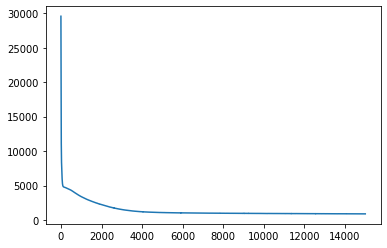

In [43]:
plt.plot(loss_hist_new)

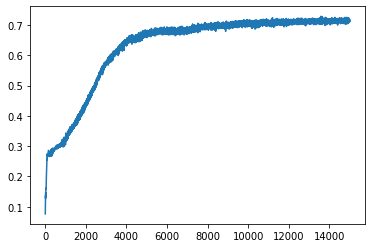

In [44]:
plt.plot(accuracy_hist_new)

In [48]:
pickle.dump(loss_hist_new, open('loss.pickle', 'wb'))
pickle.dump(accuracy_hist_new, open('accuracy.pickle', 'wb'))

In [49]:
torch.save(network.state_dict(), "modelStateDict.pth")